# 模拟退火算法

## 算法背景
模拟退火算法（Simulated Annealing, SA）源于固体退火过程的物理现象。当金属被加热至高温时，其内部粒子因热运动而处于无序高能态；随后缓慢冷却（退火），粒子逐渐趋于有序排列，最终在常温下达到稳定的低能基态（晶体结构）。若冷却过快（淬火），粒子会陷入亚稳态（局部能量陷阱），无法达到全局最低能量。

![算法基本要素](./img/basicSA.png)

![算法流程图与伪代码](img/processSA.png)

In [1]:
import numpy as np
import pandas as pd

# 首先我们求解一个旅行商问题（STP）abs
with open("./data/att48.txt") as f:
    for i, line in enumerate(f):
        if i >=10 :
            break
        print(repr(line)) #repr 会显示空格
    

'NAME : att48\n'
'COMMENT : 48 capitals of the US (Padberg/Rinaldi)\n'
'TYPE : TSP\n'
'DIMENSION : 48\n'
'EDGE_WEIGHT_TYPE : ATT\n'
'NODE_COORD_SECTION\n'
'1 6734 1453\n'
'2 2233 10\n'
'3 5530 1424\n'
'4 401 841\n'


In [2]:
df = pd.read_csv("./data/att48.txt", 
                delim_whitespace=True,
                skiprows=6, 
                header=None)

In [3]:
df.head()

,0,1,2
0,1,6734.0,1453.0
1,2,2233.0,10.0
2,3,5530.0,1424.0
3,4,401.0,841.0
4,5,3082.0,1644.0


In [4]:
coord = df.iloc[:48, 1:]
coord.head()

,1,2
0,6734.0,1453.0
1,2233.0,10.0
2,5530.0,1424.0
3,401.0,841.0
4,3082.0,1644.0


In [5]:
# 转化为numpy数组
coord = coord.values 

In [6]:
# 数据处理好了，接下来定义几个辅助函数
def clac_distance_matrix(coords):
    """计算城市之间的欧氏距离矩阵"""
    n = len(coords)
    dist = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dx = coords[i, 0] - coords[j, 0]
            dy = coords[i, 1] - coords[j, 1]
            dist[i, j]= np.sqrt(dx**2 + dy**2)
    return dist


def total_distance(path, dist_mat):
    """计算总路径"""
    n = len(path)
    # 把路径首尾相连计算总长度
    return sum(dist_mat[path[i]][path[(i+1)%n]] for i in range(n))

def perturb_tsp(path):
    """"生成新解，随机交换两个子城市或者逆序子路径"""
    new_path = path.copy()
    if np.random.rand() < 0.5:
        # 交换城市
        i, j = np.random.choice(len(path), 2, replace=False)
        new_path[i], new_path[j] = new_path[j], new_path[i]
    else:
        # 逆序片段[i,j]
        # 降序sorted抽出i《=j
        i, j = sorted(np.random.choice(len(path), 2, replace=False))
        new_path[i:j+1] = new_path[i:j+1][::-1] #从[i,j+1)切片整体反转
    return new_path

In [7]:
# 主函数--模拟退火函数
def simulated_annealing_tsp(
    coords, T0=1000, T_min=1e-5, alpha=0.99, L=100
):
    dist_mat = clac_distance_matrix(coords)
    n = len(coords)
    path = np.random.permutation(n).tolist()
    best_path = path.copy()
    best_dist = total_distance(path, dist_mat)
    T = T0
    history = [best_dist]
    no_improve_limit = 100   # 连续 500 次 best_dist 无改进就停
    no_improve_cnt   = 0
    last_best        = best_dist
    
    while T > T_min:
        for _ in range(L):
            new_path = perturb_tsp(path)
            dist_old = total_distance(path, dist_mat)
            dist_new = total_distance(new_path, dist_mat)
            deltaE = dist_new - dist_old

            if deltaE <0 or np.random.rand() < np.exp(deltaE / T):
                path = new_path
                if dist_new < best_dist:
                    best_path = new_path.copy()
                    best_dist = dist_new
            if best_dist < last_best - 1e-6:          # 1e-6 是容忍误差
                no_improve_cnt = 0
                last_best = best_dist
            else:
                no_improve_cnt += 1

            if no_improve_cnt >= no_improve_limit:      # 提前终止
                print(f"连续 {no_improve_limit} 次无改进，提前结束")
                return best_path, best_dist, history
            history.append(best_dist)
            T*=alpha # 降温
    return best_path, best_dist, history

In [8]:
best_path, best_dist, history = simulated_annealing_tsp(coord)
print(f"最短路径长度为：{best_dist}，路径为：{best_path}")

连续 100 次无改进，提前结束
最短路径长度为：126411.4602926372，路径为：[34, 42, 36, 16, 22, 29, 35, 26, 45, 2, 24, 21, 40, 13, 1, 32, 5, 20, 28, 41, 10, 23, 31, 46, 0, 19, 12, 4, 37, 15, 17, 9, 3, 6, 27, 11, 33, 18, 47, 25, 7, 43, 30, 8, 39, 14, 38, 44]


In [9]:
# history

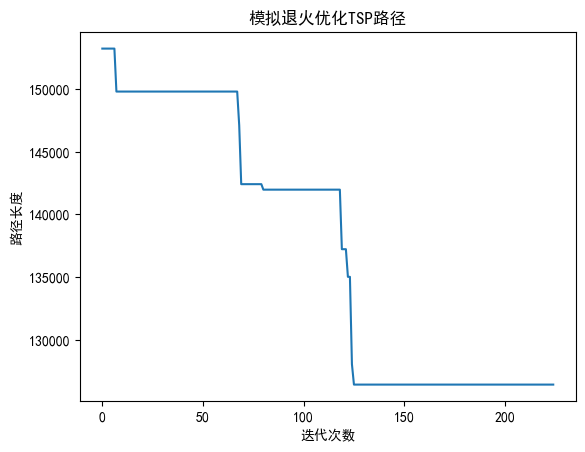

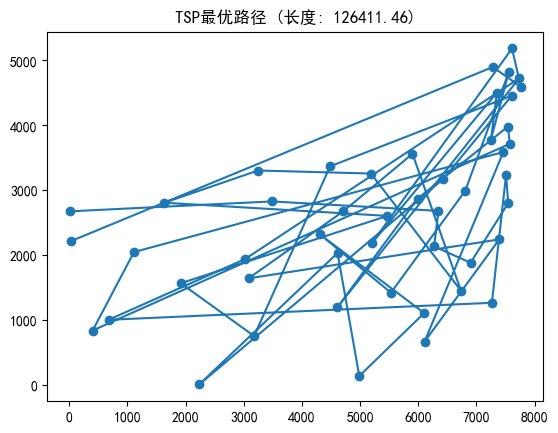

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']        # 黑体，Windows 自带
plt.rcParams['axes.unicode_minus'] = False          # 解决负号显示成方块的问题

# 绘制优化过程
plt.plot(history)
plt.xlabel('迭代次数')
plt.ylabel('路径长度')
plt.title('模拟退火优化TSP路径')
plt.show()

# 绘制路径图
x = [coord[i, 0] for i in best_path]
y = [coord[i, 1] for i in best_path]
plt.plot(x, y, 'o-')
plt.title(f'TSP最优路径 (长度: {best_dist:.2f})')
plt.show()